In [ ]:
!pip install tensorflow

Architecture: [10]
Test Loss: 0.003519
Correlation Coefficient: 0.974788
R^2 Score: 0.946612
RMSE: 0.059322

Architecture: [20]
Test Loss: 0.003704
Correlation Coefficient: 0.971947
R^2 Score: 0.943804
RMSE: 0.060862

Architecture: [10, 10]
Test Loss: 0.005769
Correlation Coefficient: 0.955437
R^2 Score: 0.912480
RMSE: 0.075953

Architecture: [20, 10]
Test Loss: 0.010586
Correlation Coefficient: 0.917129
R^2 Score: 0.839393
RMSE: 0.102891

Architecture: [20, 20]
Test Loss: 0.005091
Correlation Coefficient: 0.961612
R^2 Score: 0.922763
RMSE: 0.071352

Architecture: [10, 10, 10]
Test Loss: 0.003628
Correlation Coefficient: 0.973179
R^2 Score: 0.944961
RMSE: 0.060232

Architecture: [10, 20, 10]
Test Loss: 0.004396
Correlation Coefficient: 0.966339
R^2 Score: 0.933304
RMSE: 0.066305

Architecture: [20, 20, 20]
Test Loss: 0.005904
Correlation Coefficient: 0.957133
R^2 Score: 0.910424
RMSE: 0.076840

Best Architecture: [10]


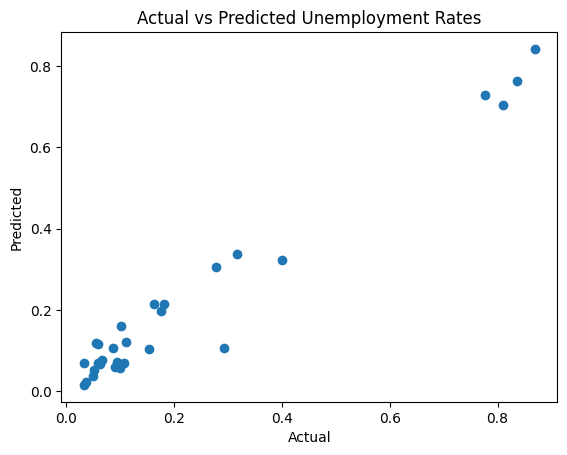

Feature Importance: [0.20058577 0.13353892 0.22218744 0.11030734 0.24463432 0.08874618]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/Cleaned_Combined_Dataset.csv'
data = pd.read_csv(file_path)

# Filter data for selected parameters including the correct unemployment rate column
parameters = [
    'Foreign direct investment, net inflows (% of GDP)',
    'General government final consumption expenditure (% of GDP)',
    'Inflation, consumer prices (annual %)',
    'Labor Productivity',
    'Population ages 15-64, total',
    'Unemployment, total (% of total labor force) (national estimate)'
]

filtered_data = data[data['Series Name'].isin(parameters)]

# Melt the data to long format
filtered_data_melted = filtered_data.melt(id_vars=["Country Name", "Series Name"], var_name="Year", value_name="Value")

# Replace non-numeric values with NaN
filtered_data_melted['Value'] = filtered_data_melted['Value'].replace('..', np.nan)

# Convert the "Value" column to numeric
filtered_data_melted['Value'] = pd.to_numeric(filtered_data_melted['Value'], errors='coerce')

# Pivot the table to have countries as rows and years as columns for each parameter
pivoted_data = filtered_data_melted.pivot_table(index=["Country Name", "Year"], columns="Series Name", values="Value").reset_index()

# Fill any missing values with the column mean after conversion
pivoted_data = pivoted_data.fillna(pivoted_data.mean(numeric_only=True))

# Rename the unemployment rate column for simplicity
pivoted_data.rename(columns={'Unemployment, total (% of total labor force) (national estimate)': 'Unemployment rate'}, inplace=True)

# Normalize the data
scaler = MinMaxScaler()
pivoted_data.iloc[:, 2:] = scaler.fit_transform(pivoted_data.iloc[:, 2:])

# Add lagged unemployment rate (shift data by one year per country)
pivoted_data["Lagged Unemployment rate"] = pivoted_data.groupby("Country Name")["Unemployment rate"].shift(1)

# Drop rows with missing values due to lagged unemployment rate creation
pivoted_data.dropna(inplace=True)

# Prepare input (X) and output (y) variables
X = pivoted_data.drop(columns=["Country Name", "Year", "Unemployment rate"]).values
y = pivoted_data["Unemployment rate"].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define different architectures
architectures = [
    [10],          # Single hidden layer with 10 neurons
    [20],          # Single hidden layer with 20 neurons
    [10, 10],      # Two hidden layers with 10 neurons each
    [20, 10],      # Two hidden layers with 20 and 10 neurons
    [20, 20],      # Two hidden layers with 20 and 20 neurons
    [10, 10, 10],  # Three hidden layers with 10, 10, and 10 neurons
    [10, 20, 10],  # Three hidden layers with 10, 20, and 10 neurons
    [20, 20, 20],  # Three hidden layers with 20, 20, and 20 neurons
]

results = []

# Define the neural network model
class ANNModel(nn.Module):
    def __init__(self, layers):
        super(ANNModel, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                self.layers.append(nn.Tanh())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Train and evaluate each architecture
for architecture in architectures:
    input_dim = X_train.shape[1]
    layers = [input_dim] + architecture + [1]
    model = ANNModel(layers)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Train the model
    num_epochs = 2000
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(torch.tensor(X_train, dtype=torch.float32))
        loss = criterion(outputs, torch.tensor(y_train, dtype=torch.float32).view(-1, 1))
        loss.backward()
        optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(torch.tensor(X_test, dtype=torch.float32))
        test_loss = criterion(y_pred_tensor, torch.tensor(y_test, dtype=torch.float32).view(-1, 1))

    y_pred = y_pred_tensor.numpy()
    correlation = np.corrcoef(y_test, y_pred[:, 0])[0, 1]
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(test_loss.item())

    # Store the results
    results.append({
        'architecture': architecture,
        'test_loss': test_loss.item(),
        'rmse': rmse,
        'correlation': correlation,
        'r2_score': r2
    })

    print(f'Architecture: {architecture}')
    print(f'Test Loss: {test_loss.item():.6f}')
    print(f'Correlation Coefficient: {correlation:.6f}')
    print(f'R^2 Score: {r2:.6f}')
    print(f'RMSE: {rmse:.6f}')
    print()

# Plot results for the best architecture
best_architecture = max(results, key=lambda x: x['r2_score'])
print(f'Best Architecture: {best_architecture["architecture"]}')

model = ANNModel([input_dim] + best_architecture['architecture'] + [1])
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the best model again
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(torch.tensor(X_train, dtype=torch.float32))
    loss = criterion(outputs, torch.tensor(y_train, dtype=torch.float32).view(-1, 1))
    loss.backward()
    optimizer.step()

model.eval()
with torch.no_grad():
    y_pred_tensor = model(torch.tensor(X_test, dtype=torch.float32))
y_pred = y_pred_tensor.numpy()

plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Unemployment Rates')
plt.show()

# Calculate feature importance using Garson's Algorithm
def garson_weights(model):
    weights = model.layers[0].weight.data.numpy()
    abs_weights = np.abs(weights)
    row_sums = abs_weights.sum(axis=1)
    normalized_weights = abs_weights / row_sums[:, np.newaxis]
    importances = normalized_weights.sum(axis=0)
    return importances / importances.sum()

feature_importance = garson_weights(model)
print(f'Feature Importance: {feature_importance}')


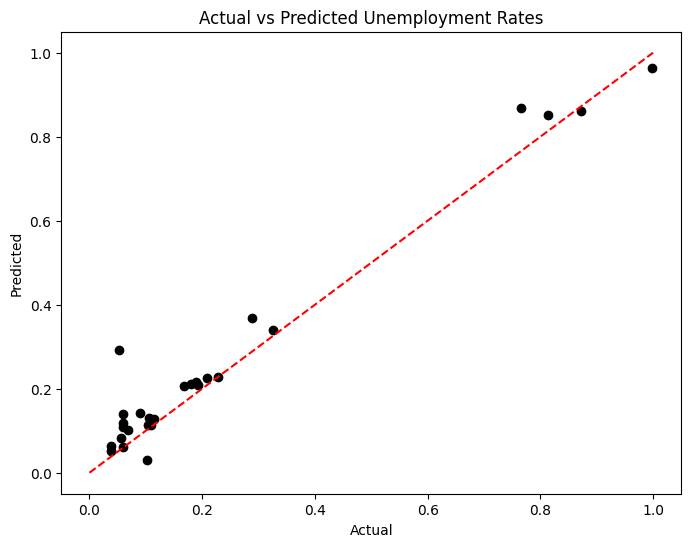

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Evaluate the best model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(torch.tensor(X_test, dtype=torch.float32))
y_pred = y_pred_tensor.numpy()

# Plot Actual vs Predicted Unemployment Rates
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='black')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Unemployment Rates')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show()

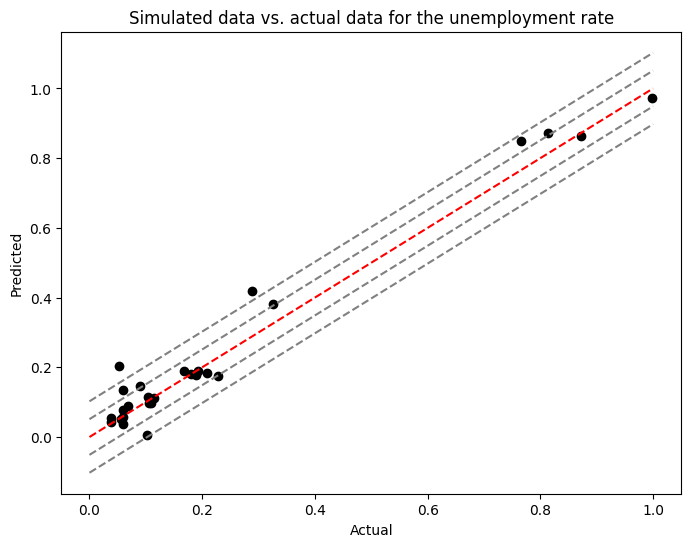

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


model.eval()
with torch.no_grad():
    y_pred_tensor = model(torch.tensor(X_test, dtype=torch.float32))
y_pred = y_pred_tensor.numpy()

# Plot Actual vs Predicted Unemployment Rates
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='black')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Simulated data vs. actual data for the unemployment rate')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

# Calculate standard errors
errors = y_test - y_pred[:, 0]
std_error = np.std(errors)

# Add error bands
plt.plot([0, 1], [std_error, 1 + std_error], color='grey', linestyle='--')
plt.plot([0, 1], [-std_error, 1 - std_error], color='grey', linestyle='--')
plt.plot([0, 1], [2*std_error, 1 + 2*std_error], color='grey', linestyle='--')
plt.plot([0, 1], [-2*std_error, 1 - 2*std_error], color='grey', linestyle='--')

plt.show()

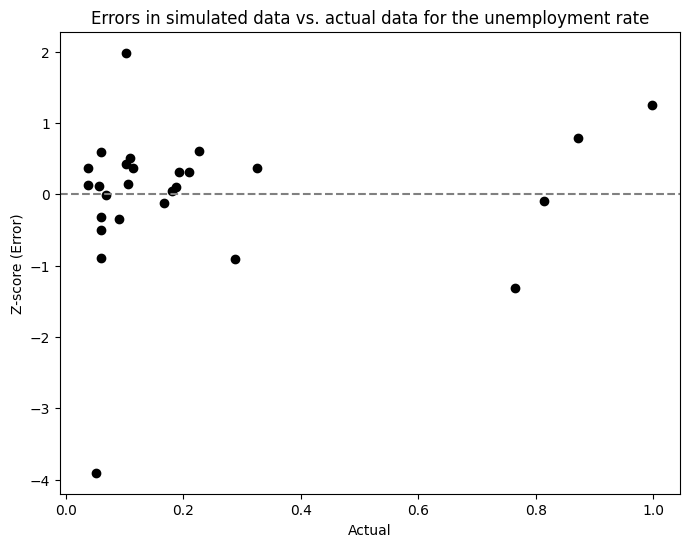

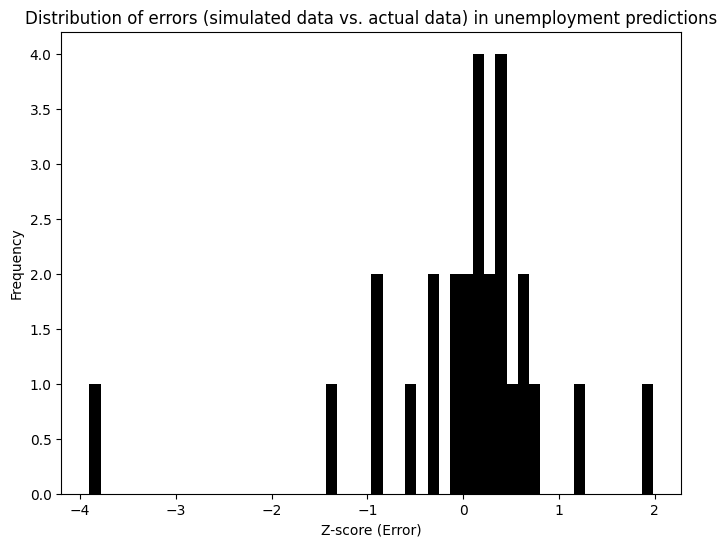

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Assuming you have already loaded and preprocessed the data as in the previous steps

# Evaluate the best model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(torch.tensor(X_test, dtype=torch.float32))
y_pred = y_pred_tensor.numpy()

# Calculate the errors
errors = y_test - y_pred[:, 0]

# Calculate the Z-scores of the errors
z_scores = zscore(errors)

# Plot Z-scores vs Actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, z_scores, color='black')
plt.axhline(0, color='grey', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Z-score (Error)')
plt.title('Errors in simulated data vs. actual data for the unemployment rate')
plt.show()

# Plot the distribution of Z-scores (errors)
plt.figure(figsize=(8, 6))
plt.hist(z_scores, bins=50, color='black')
plt.xlabel('Z-score (Error)')
plt.ylabel('Frequency')
plt.title('Distribution of errors (simulated data vs. actual data) in unemployment predictions')
plt.show()


Architecture: [10]
Test Loss: 0.003949
Correlation Coefficient: 0.980509
R^2 Score: 0.947277
RMSE: 0.062839

Architecture: [20]
Test Loss: 0.003704
Correlation Coefficient: 0.981781
R^2 Score: 0.950544
RMSE: 0.060860

Architecture: [10, 10]
Test Loss: 0.007305
Correlation Coefficient: 0.957872
R^2 Score: 0.902467
RMSE: 0.085468

Architecture: [20, 10]
Test Loss: 0.006446
Correlation Coefficient: 0.964785
R^2 Score: 0.913931
RMSE: 0.080288

Architecture: [20, 20]
Test Loss: 0.003409
Correlation Coefficient: 0.980889
R^2 Score: 0.954481
RMSE: 0.058388

Architecture: [10, 10, 10]
Test Loss: 0.003538
Correlation Coefficient: 0.979134
R^2 Score: 0.952760
RMSE: 0.059481

Architecture: [10, 20, 10]
Test Loss: 0.002776
Correlation Coefficient: 0.983761
R^2 Score: 0.962937
RMSE: 0.052686

Architecture: [20, 20, 20]
Test Loss: 0.006208
Correlation Coefficient: 0.960901
R^2 Score: 0.917116
RMSE: 0.078788

Best Architecture: [10, 20, 10]


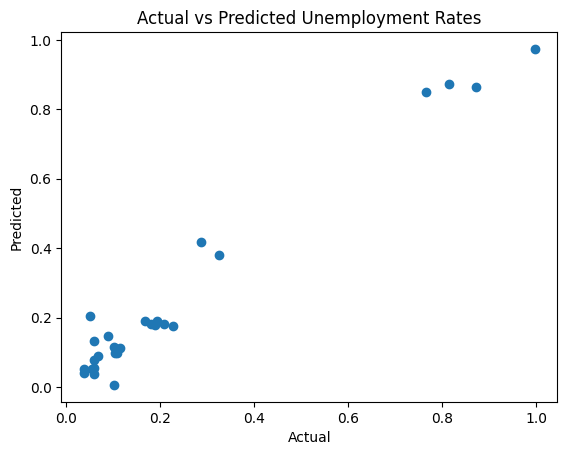

Feature Importance: [0.15541957 0.1292148  0.08689858 0.13276605 0.25512797 0.10317273
 0.13740028]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Load the merged dataset
file_path = '/content/Merged_Dataset.csv'
data = pd.read_csv(file_path)

# Filter data for selected parameters including the correct unemployment rate column
parameters = [
    'Patents',
    'Foreign direct investment, net inflows (% of GDP)',
    'General government final consumption expenditure (% of GDP)',
    'Inflation, consumer prices (annual %)',
    'Labor Productivity',
    'Population ages 15-64, total',
    'Unemployment, total (% of total labor force) (national estimate)'
]

filtered_data = data[data['Series Name'].isin(parameters)]

# Melt the data to long format
filtered_data_melted = filtered_data.melt(id_vars=["Country Name", "Series Name"], var_name="Year", value_name="Value")

# Replace non-numeric values with NaN
filtered_data_melted['Value'] = filtered_data_melted['Value'].replace('..', np.nan)

# Convert the "Value" column to numeric
filtered_data_melted['Value'] = pd.to_numeric(filtered_data_melted['Value'], errors='coerce')

# Pivot the table to have countries as rows and years as columns for each parameter
pivoted_data = filtered_data_melted.pivot_table(index=["Country Name", "Year"], columns="Series Name", values="Value").reset_index()

# Fill any missing values with the column mean after conversion
pivoted_data = pivoted_data.fillna(pivoted_data.mean(numeric_only=True))

# Rename the unemployment rate column for simplicity
pivoted_data.rename(columns={'Unemployment, total (% of total labor force) (national estimate)': 'Unemployment rate'}, inplace=True)

# Normalize the data
scaler = MinMaxScaler()
pivoted_data.iloc[:, 2:] = scaler.fit_transform(pivoted_data.iloc[:, 2:])

# Add lagged unemployment rate (shift data by one year per country)
pivoted_data["Lagged Unemployment rate"] = pivoted_data.groupby("Country Name")["Unemployment rate"].shift(1)

# Drop rows with missing values due to lagged unemployment rate creation
pivoted_data.dropna(inplace=True)

# Prepare input (X) and output (y) variables
X = pivoted_data.drop(columns=["Country Name", "Year", "Unemployment rate"]).values
y = pivoted_data["Unemployment rate"].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define different architectures
architectures = [
    [10],          # Single hidden layer with 10 neurons
    [20],          # Single hidden layer with 20 neurons
    [10, 10],      # Two hidden layers with 10 neurons each
    [20, 10],      # Two hidden layers with 20 and 10 neurons
    [20, 20],      # Two hidden layers with 20 and 20 neurons
    [10, 10, 10],  # Three hidden layers with 10, 10, and 10 neurons
    [10, 20, 10],  # Three hidden layers with 10, 20, and 10 neurons
    [20, 20, 20],  # Three hidden layers with 20, 20, and 20 neurons
]

results = []

# Define the neural network model
class ANNModel(nn.Module):
    def __init__(self, layers):
        super(ANNModel, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                self.layers.append(nn.Tanh())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Train and evaluate each architecture
for architecture in architectures:
    input_dim = X_train.shape[1]
    layers = [input_dim] + architecture + [1]
    model = ANNModel(layers)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Train the model
    num_epochs = 2000
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(torch.tensor(X_train, dtype=torch.float32))
        loss = criterion(outputs, torch.tensor(y_train, dtype=torch.float32).view(-1, 1))
        loss.backward()
        optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(torch.tensor(X_test, dtype=torch.float32))
        test_loss = criterion(y_pred_tensor, torch.tensor(y_test, dtype=torch.float32).view(-1, 1))

    y_pred = y_pred_tensor.numpy()
    correlation = np.corrcoef(y_test, y_pred[:, 0])[0, 1]
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(test_loss.item())

    # Store the results
    results.append({
        'architecture': architecture,
        'test_loss': test_loss.item(),
        'rmse': rmse,
        'correlation': correlation,
        'r2_score': r2
    })

    print(f'Architecture: {architecture}')
    print(f'Test Loss: {test_loss.item():.6f}')
    print(f'Correlation Coefficient: {correlation:.6f}')
    print(f'R^2 Score: {r2:.6f}')
    print(f'RMSE: {rmse:.6f}')
    print()

# Plot results for the best architecture
best_architecture = max(results, key=lambda x: x['r2_score'])
print(f'Best Architecture: {best_architecture["architecture"]}')

model = ANNModel([input_dim] + best_architecture['architecture'] + [1])
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the best model again
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(torch.tensor(X_train, dtype=torch.float32))
    loss = criterion(outputs, torch.tensor(y_train, dtype=torch.float32).view(-1, 1))
    loss.backward()
    optimizer.step()

model.eval()
with torch.no_grad():
    y_pred_tensor = model(torch.tensor(X_test, dtype=torch.float32))
y_pred = y_pred_tensor.numpy()

plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Unemployment Rates')
plt.show()

# Calculate feature importance using Garson's Algorithm
def garson_weights(model):
    weights = model.layers[0].weight.data.numpy()
    abs_weights = np.abs(weights)
    row_sums = abs_weights.sum(axis=1)
    normalized_weights = abs_weights / row_sums[:, np.newaxis]
    importances = normalized_weights.sum(axis=0)
    return importances / importances.sum()

feature_importance = garson_weights(model)
print(f'Feature Importance: {feature_importance}')


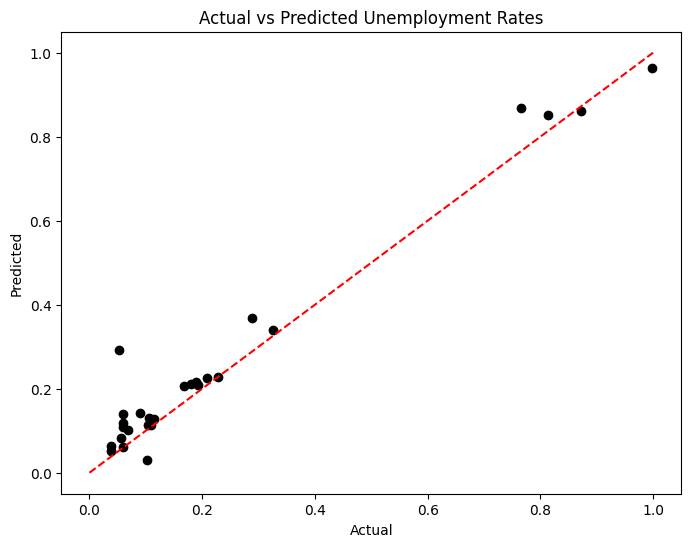

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Evaluate the best model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(torch.tensor(X_test, dtype=torch.float32))
y_pred = y_pred_tensor.numpy()

# Plot Actual vs Predicted Unemployment Rates
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='black')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Unemployment Rates')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show()